#Hillary Talks

I am analysing the HCM dataset to identify trends in the foreign policy along the time. The work is based on the approach by [Olalekan](https://www.kaggle.com/ampaho/d/kaggle/hillary-clinton-emails/foreign-policy-map-through-hrc-s-emails/code) but extended to the whole dataset. It is also mainly in python instead of R as Olalekan code, but inserts R code in particular to use the R's countrycode package. I applied some modifications on the proposed job by Olalekan.

Also in the same fashion as Olalekan I added a visualization but in d3.js that can be found on [this link]().

The second part of this project is very much in the same fashion as [D Kelly](https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb) with some small modifications. I copied some of his work and made a few modifications. Both works are absolutely comparable in methodology but not totally on results.

The code below is far from being optimised and it is for "playing" purposes. It was based on python3 and used recent extensions for connecting to R.


In [1]:
import os, sys
import csv
#http://blog.revolutionanalytics.com/2016/01/pipelining-r-python.html
%load_ext rpy2.ipython
import numpy, scipy, pandas
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
from collections import Counter
import datetime
import sqlite3
import zipfile
import nltk, re
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Modeling: Part 1
#from textblob import TextBlob
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

conn = sqlite3.connect('.../hc_emails/output/database.sqlite')
c = conn.cursor()

###Extraction of data (mails and dates) from SQLite to pandas

In [2]:
import pandas.io.sql as psql
sql = "SELECT MetadataSubject as MetadataSubject, SUBSTR(MetadataDateSent,1,7) as SentFOIA, ExtractedDateSent as Sent, ExtractedBodyText as EmailBody FROM Emails a WHERE ExtractedBodyText != '' AND MetadataDateSent != '' ORDER BY MetadataDateSent"
df = psql.frame_query(sql, conn)
#df = df.iloc[:100,:]
#df
#sql2 = "SELECT SUBSTR(MetadataDateSent,1,7) as SentFOIA, ExtractedDateSent as Sent, ExtractedBodyText as EmailBody, RawText FROM Emails a WHERE ExtractedBodyText != '' AND MetadataDateSent != '' ORDER BY MetadataDateSent"
#df2 = psql.frame_query(sql2, conn)
#df['EmailBody'][4]

.../io/sql.py:1569: FutureWarning: frame_query is deprecated, use read_sql
  warnings.warn("frame_query is deprecated, use read_sql", FutureWarning)


###Using and preparing R's countrycode dataset

In [3]:
%%R -o words_to_be_removed -o countries
library(qdapDictionaries)
library(countrycode)
data(countrycode_data)
#we assume that a country could be referred to as its full name or its ISO3 code
#ec:: OJO with above ^^
#as abbreviation so we get the list of countries
#ec:: list of country names that will be not considered, including USA
#ec:: USA (255) is excluded because we are interested only in foreign policy

#countrycode_data[,c('country.name','iso2c','iso3c','regex')]

words_to_remove <- rbind(DICTIONARY[nchar(DICTIONARY$word)==2,], DICTIONARY[nchar(DICTIONARY$word)==3,])
words_to_be_removed <- toupper(c(words_to_remove$word, "RE", "FM", "TV", "LA", "AL", "BEN", "AQ"))

## ec:: the only accepted countries
## ec:: as we will see later, regex is a prepared dataset that includes a pattern to find country.name (NICE!!!)
#countries <- countrycode_data[, c("country.name", "regex", "iso2c", "iso3c")]
#countries <- countrycode_data[-83,]


#countries$other <- NA
## ec:: not clear for me why UK is left apart as "other"
#countries[countries$country.name=="United Kingdom",]$other <- "UK"
##head(countrycode_data_without_atf)
##head(countries)
##countries[countries$country.name=="United Kingdom",]
##countrycode_data_without_atf[with(countrycode_data_without_atf,  grepl("Russia", country.name)),]
##countries[countries$country.name=="Saint Pierre and Miquelon"]
#countrycode_data[countrycode_data$country.name == 'Haiti',]

 countries <- countrycode_data                   [-c(2,
                                                     5,
                                                     6,
                                                     9,
                                                     16,
                                                     23,
                                                     31,
                                                     32,
                                                     34,
                                                     36,
                                                     50,
                                                     51,
                                                     56,
                                                     61,
                                                     64,
                                                     66,
                                                     76,
                                                     77,
                                                     83,
                                                     87,
                                                     88,
                                                     91,
                                                     98,
                                                     103,
                                                     104,
                                                     105,
                                                     106,
                                                     117,
                                                     122,
                                                     130,
                                                     143,
                                                     154,
                                                     155,
                                                     158,
                                                     177,
                                                     183,
                                                     188,
                                                     191,
                                                     201,
                                                     202,
                                                     203,
                                                     204,
                                                     205,
                                                     206,
                                                     207,
                                                     209,
                                                     210,
                                                     212,
                                                     215,
                                                     218,
                                                     224,
                                                     230,
                                                     241,
                                                     248,
                                                     249,
                                                     250,
                                                     255,
                                                     256,
                                                     262,
                                                     263,
                                                     264,
                                                     266,
                                                     270),] 
 


#countries

###End of Sentence Detection; Tokenization; POS tagging; Word Removal

In [4]:
#df = df.iloc[0:30,:]
df_countries = pandas2ri.ri2py(countries)

def RegexCountries(txt):
    for index, rowc in df_countries.iterrow():
        prog1 = re.compile(r'{0}'.format(rowc['regex']))
        if prog1.search(joinedline) != None:
            txt = re.sub(prog1, rowc['country.name'].split(',')[0]+" ", txt)
    return txt


def EoS(t):
    return nltk.tokenize.sent_tokenize(t)

def Tok(ss):
    return [nltk.tokenize.word_tokenize(s) for s in ss]

def POS(ts):
    return [nltk.pos_tag(t) for t in ts]


usual_stopwords = nltk.corpus.stopwords.words('english')

punctuation = ["(",")",".",",",":","=","{","}","==", "===","[","]","+","++","-","--","_","<",">","'","''","``",'"',"!","!=","?",";","/","\\", "\\\\", "/", "//"]

#from Doug Kelly work
specific_stopwords = ['foia', 'waiver', 'classified', 'unclassified', 
                 'redactions', 'sensitive', 'clintonemail', 'department', 
                 'dept', 'mailto', 'subject', 'fw', 'cc', 'state', 'send', 
                 'sent', 'comm', 'cheryl', 'mills', 'sullivan', 'www', 'url', 
                 'http', 'xml', 'html', 'org']
#from Olalekan's work
short_words = [w.lower() for w in pandas2ri.ri2py(words_to_be_removed).tolist()]
other_words = ["re", "fm", "tv", "la", "al", "ben", "aq", "ca", "can", "can'", "can't", "cant"]
other_words = []

wtbr = usual_stopwords + specific_stopwords + short_words + other_words + punctuation

def WordRem(ts):
    #Parsing the messages in the pandas file to identify possible undesired words
      #return [(w[0].lower(), w[1]) for w in ts if w[0].lower() not in wtbr]
    final = []
    for t in ts:
        if t[0].lower() not in wtbr:
            final.append((t[0].lower(), t[1]))
        #else:
            #assert t[0].lower() == 'can'
            #print(t[0].lower())
    #print(final)
    return final
    #print([(w[0].lower(), w[1]) for w in ts if w[0].lower() not in wtbr])
    #return [(w[0].lower(), w[1]) for w in ts if w[0].lower() not in wtbr]
    
#def sw(x):
#    x = x.split()
#    for i,w in enumerate(x):
#        #if w in [wrds for wrds in nltk.corpus.words.words() if len(w) <= 3] + ["re", "fm", "tv", "la", "al", "ben", "aq"]:
#        #"ago", "us", "il", "isr", 
#        if w in  + list_words_to_be_removed + new_stopwords + :
#            x[i] = 'stopword'
#    return ' '.join(x)    
    
def extending_lists(ls):
    if len(ls) > 0:
        totalls = []
        for l in ls:
            totalls.extend(l)
    return totalls


df_countries = pandas2ri.ri2py(countries)
foundpattern = []


def pretreatment(txt):
    #txt = txt.split()
    #print(txt)
    sentences = EoS(txt)
    #print(sentences)
    tokens = Tok(sentences)
    #print(tokens)
    tagged_tokens = POS(tokens)
    #print(tagged_tokens)
    extended_list = extending_lists(tagged_tokens)
    #print(extended_list)
    return WordRem(extended_list)


#from Doug Kelly work
def tags_filter(text):
    """
    Experiment to just use Nouns, Verbs, Adjectives
    """
    blob = TextBlob(text).tags
    words = []
    for blob_tags in blob:
        # Nouns
        if blob_tags[1] in ("NN", "NNS", "NNP", "NNPS"):
            words.append(blob_tags[0])
        # Verbs
        if blob_tags[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ"):
            words.append(blob_tags[0])
        # Adj
#         if blob_tags[1] in ("RB", "RBR", "RBS"):
#             words.append(blob_tags[0])
        words = [w for w in words if len(w) > 1]

    return " ".join(words)



In [5]:
#short_words
#wtbr

In [6]:
#test = pretreatment(df['EmailBody'][4])
#print(test)
#df['EmailBody'] = df['EmailBody'].str.lower()
df['EmailBody'] = df['EmailBody'].apply(pretreatment)
df.head()

,MetadataSubject,SentFOIA,Sent,EmailBody
0,SECRETARY OF STATE HILLARY RODHAM CLINTON ADDR...,2009-01,"Monday, December 21, 2009 2:33 PM","[(folks, NNS), ('ve, VBP), (attached, VBN), (l..."
1,,2009-03,"Thursday, March 19, 2009 12:24 PM","[(talking, VBG), (points, NNS), (secretary, NN..."
2,TALKING POINTS FOR CALL WITH SEN FEINSTEIN AN...,2009-03,,"[(cherylmill5, NNP), (friday, NNP), (march, NN..."
3,TALKING POINTS FOR CALL WITH SEN FEINSTEIN AN...,2009-03,"Friday, March 20, 20098:05 AM","[('ve, VBP), (printed, VBN), (give, VB), (copy..."
4,AP/NEW MEDIA,2009-03,"Saturday, March 21, 2009 11:21 AM","[(story, NNP), (good, JJ), (straightforward, J..."


###Generation of a list to extract countries found at each EmailBody
The list is organised by position in the original dataset and consist in a tuple of country name, continent and region per location found at each EmailBody.
In this case, only one record of the country is included if found at least one time in the text.

In [7]:
#def match_regex(string, prog):
#    return re.match(prog, string)

import copy

foundpattern = []
for i, rowdf in df.iterrows():
    p = []
    for j,rowc in df_countries.iterrows():
        counter = 0
        #joinedline = ' '.join([w[0] for w in rowdf['EmailBody']])
        
        #if prog1.search(joinedline) != None:
            #print(joinedline)
            #prog2 = re.compile(r'{0}'.format(rowc['regex']))
            #newjoinedline = re.sub(prog2, rowc['iso3c'], joinedline)
            #prog3 = re.compile(r'{0}\w+'.format(rowc['iso3c']))
            #newjoinedline = re.sub(prog3, rowc['iso3c']+'\s', newjoinedline)
            #print(newjoinedline)
            #pos = numpy.where(numpy.array(newjoinedline.split()) == rowc['iso3c'])[0]  
            #pos = prog1.search(joinedline).span()
            #if len(newjoinedline.split()) < len(joinedline.split()):
                #cc = copy.deepcopy(rowdf['EmailBody'])
                #start = 0
                #for ps in pos:
                #    rowdf['EmailBody'][ps-start] = (rowc['iso3c'], rowdf['EmailBody'][ps-start][1])
                #    rowdf['EmailBody'] = rowdf['EmailBody'][start:ps+1-start] + rowdf['EmailBody'][ps+1-start:]
                #    start = ps+1
            #else:
                #print(pos)
            #    for ps in pos:
            #        rowdf['EmailBody'][ps] = (rowc['iso3c'], rowdf['EmailBody'][ps][1])
        for i,tk in enumerate(rowdf['EmailBody']):
            #first find pattern
            #prog = re.compile(r'\W?'+rowc['regex']+'\w+.?\W?')
            
            #if re.match(prog, tk[0]):
            #    if counter == 0:
            #        counter = 1
            #        p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
            #    rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            if tk[0] == rowc['country.name'].lower().split(',')[0]:
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            elif tk[0] == 'uk' or tk[0] == 'gb':
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            elif tk[0] == rowc['iso2c'].lower():
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            elif tk[0] == rowc['iso3c'].lower():
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
                #continue
    #break
        
            
        
    foundpattern.append(p)
#foundpattern[:100]



In [8]:
#an error here
#foundpattern[:100]

In [9]:
#df['EmailBody'][4]

In [10]:
#rowc['iso3c'] , pos, len(rowdf['EmailBody']), rowc['iso3c'], rowdf['EmailBody'], joinedline, newjoinedline#rowdf['EmailBody'][ps][1],

In [11]:
#an error here

###Counting Countries, Continents and Regions: Total

Totals of the number of references to countries, continents and regions for all the messages. If several countries of similar region/continent are found in the same message, those regions and continents are counted only once.

In [12]:
countrycounter = Counter()
continentcounter = Counter()
regioncounter = Counter()
for elem in foundpattern:
    if elem == []: continue
    donecontinentorregion = set()
    for e in elem:
        countrycounter.update([e[0]])
        if e[1] not in donecontinentorregion:
            continentcounter.update([e[1]])
            donecontinentorregion.update([e[1]])
        if e[2] not in donecontinentorregion:
            regioncounter.update([e[2]])
            donecontinentorregion.update([e[2]])

In [13]:
#rowdf['EmailBody'][i]
#joinedline

In [14]:
countrycounter

Counter({'Afghanistan': 153, 'Canada': 149, 'Iran, Islamic Republic of': 107, 'China': 90, 'Israel': 89, 'Haiti': 76, 'Pakistan': 74, 'Iraq': 70, 'Libya': 58, 'India': 55, 'Germany': 48, 'Korea': 43, 'Mexico': 38, 'Montserrat': 35, 'Jamaica': 35, 'Ireland': 34, 'Egypt': 33, 'France': 31, 'Turkey': 30, 'Honduras': 27, 'Brazil': 26, 'Ethiopia': 25, 'Japan': 25, 'Jordan': 23, 'Poland': 22, 'Indonesia': 22, 'Cuba': 20, 'Colombia': 20, 'Spain': 19, 'Singapore': 18, 'Australia': 17, 'Congo, the Democratic Republic of the': 15, 'Palestine, State of': 15, 'Sudan': 15, 'Nicaragua': 15, 'Puerto Rico': 14, 'Qatar': 14, 'Argentina': 13, 'Norway': 12, 'Yemen': 12, 'Chile': 12, 'Estonia': 12, 'Thailand': 12, 'Venezuela, Bolivarian Republic of': 11, 'Sweden': 11, 'Italy': 11, 'Barbados': 11, 'Ukraine': 9, 'Lithuania': 9, 'Tunisia': 9, 'Georgia': 9, 'Northern Mariana Islands': 9, 'Philippines': 9, 'Angola': 9, 'Greece': 9, 'Costa Rica': 9, 'Morocco': 9, 'Ecuador': 8, 'Kenya': 8, 'Uruguay': 8, 'Moldova

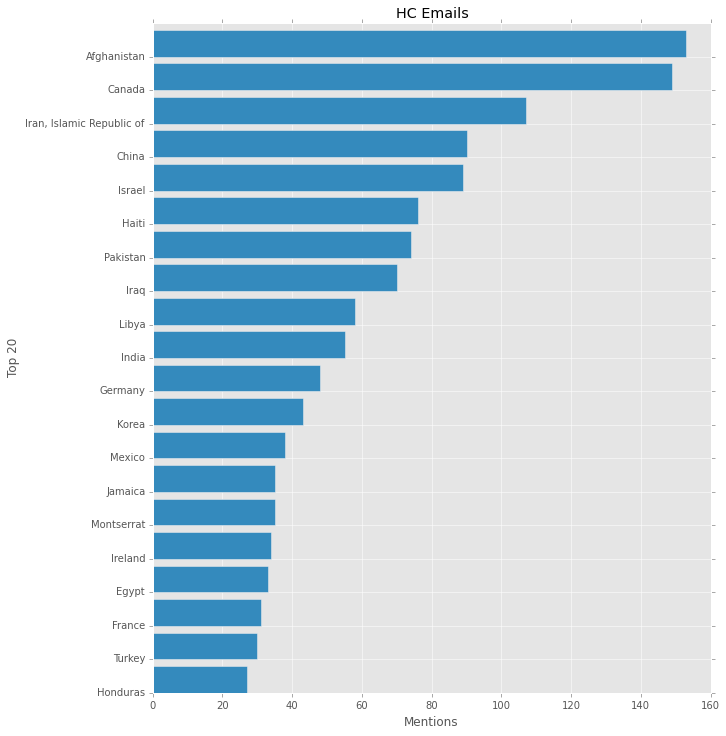

[('Afghanistan', 153), ('Canada', 149), ('Iran, Islamic Republic of', 107), ('China', 90), ('Israel', 89), ('Haiti', 76), ('Pakistan', 74), ('Iraq', 70), ('Libya', 58), ('India', 55), ('Germany', 48), ('Korea', 43), ('Mexico', 38), ('Montserrat', 35), ('Jamaica', 35), ('Ireland', 34), ('Egypt', 33), ('France', 31), ('Turkey', 30), ('Honduras', 27)]


In [15]:
#https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb
#countriestoplot = sorted(list(countrycounter.items()), key=lambda x: x[1], reverse=True)[:20]
countriestoplot = sorted(countrycounter.most_common(20), key = lambda x: x[1])
y,x = zip(*countriestoplot)

plt.figure(figsize=(10,12))

plt.barh(list(range(len(x))), x)
plt.yticks(list(range(len(x))), y, ha='right')

plt.title('HC Emails')
plt.ylabel('Top 20')
plt.xlabel('Mentions')
plt.show()
print(countrycounter.most_common(20))

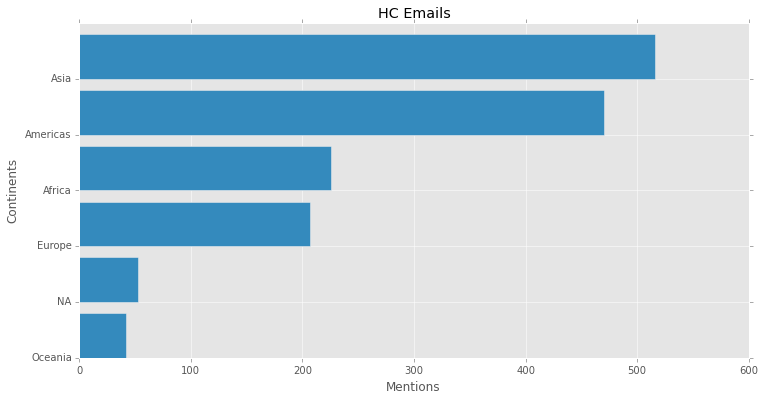

Counter({'Asia': 516, 'Americas': 470, 'Africa': 226, 'Europe': 207, 'NA': 53, 'Oceania': 42})


In [16]:
y,x = zip(*sorted(list(continentcounter.items()), key = lambda x: x[1]))

plt.figure(figsize=(12,6))

plt.barh(list(range(len(x))), x)
plt.yticks(list(range(len(x))), y, ha='right')

plt.title('HC Emails')
plt.ylabel('Continents')
plt.xlabel('Mentions')
plt.show()
print(continentcounter)

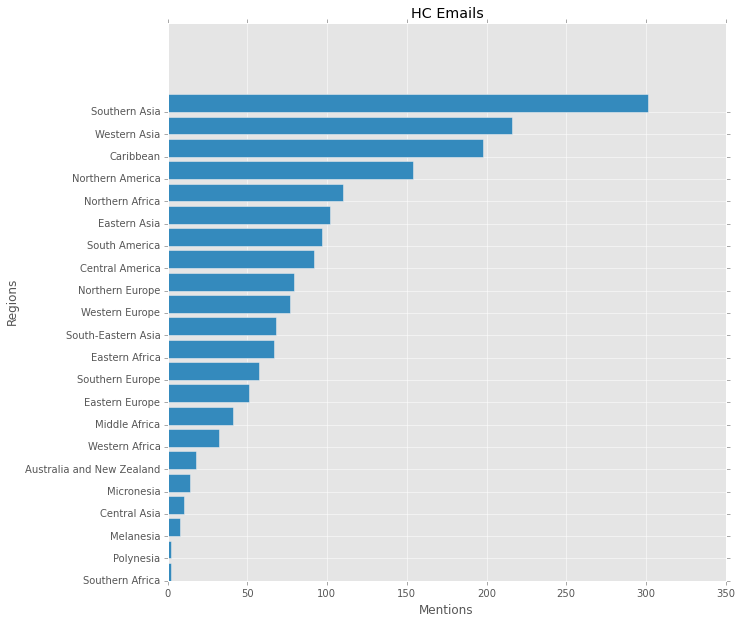

Counter({'Southern Asia': 301, 'Western Asia': 216, 'Caribbean': 198, 'Northern America': 154, 'Northern Africa': 110, 'Eastern Asia': 102, 'South America': 97, 'Central America': 92, 'Northern Europe': 79, 'Western Europe': 77, 'South-Eastern Asia': 68, 'Eastern Africa': 67, 'Southern Europe': 57, 'Eastern Europe': 51, 'Middle Africa': 41, 'Western Africa': 32, 'Australia and New Zealand': 18, 'Micronesia': 14, 'Central Asia': 10, 'Melanesia': 8, 'Southern Africa': 2, 'Polynesia': 2})


In [17]:
y,x = zip(*sorted(list(regioncounter.items()), key = lambda x: x[1]))

plt.figure(figsize=(10,10))

plt.barh(list(range(len(x))), x)
plt.yticks(list(range(len(x))), y, ha='right')

plt.title('HC Emails')
plt.ylabel('Regions')
plt.xlabel('Mentions')
plt.show()
print(regioncounter)

###Counting Countries, Continents and Regions per Year-Month

A similar counting as above but grouped by year-month.

In [18]:
#maxtime = datetime.datetime.strptime(df.SentFOIA.max(),"%Y-%M")
maxtime = datetime.date(int(df.SentFOIA.max()[:4]),int(df.SentFOIA.max()[5:7]), 1)
#print(maxtime)
#mintime = datetime.datetime.strptime(df.SentFOIA.min(),"%Y-%M")
mintime = datetime.date(int(df.SentFOIA.min()[:4]),int(df.SentFOIA.min()[5:7]), 1)
#print(mintime)
##http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html
##https://pymotw.com/2/datetime/
##http://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
#current = datetime.datetime(mintime.year, 12, 1)
#print(current)
#next_month = datetime.date(mintime.year + int(12 / 12), (int(12 % 12) + 1), 1)
#print(next_month)
dates = [mintime]
end = 0
print((maxtime-mintime).days)
next_month = mintime
#print(next_month)
while end==0:
    print((maxtime-next_month).days)
    if (maxtime - next_month).days <= 31:
        end = 1
    datetocheck = dates[-1]
    current = datetime.date(datetocheck.year, datetocheck.month, 1)
    next_month = datetime.date(datetocheck.year + int(datetocheck.month / 12), (int(datetocheck.month % 12) + 1), 1)
    dates.append(next_month)
dates



dateddata = dict([(d,[Counter(),Counter(),Counter(), Counter()]) for d in dates])


for ii, d in enumerate(df.SentFOIA):
    elem = foundpattern[ii]
    #print(elem)
    current = datetime.date(int(d[:4]),int(d[5:7]),1)
    if elem == []: continue
    donecontinentorregion = set()
    for e in elem:
        #print(e)
        dateddata[current][0].update([e[0]])
        dateddata[current][3].update([e[3]])
        if e[1] not in donecontinentorregion:
            dateddata[current][1].update([e[1]])
            donecontinentorregion.update([e[1]])
        if e[2] not in donecontinentorregion:
            dateddata[current][2].update([e[2]])
            donecontinentorregion.update([e[2]])



2160
2160
2129
2101
2070
2040
2009
1979
1948
1917
1887
1856
1826
1795
1764
1736
1705
1675
1644
1614
1583
1552
1522
1491
1461
1430
1399
1371
1340
1310
1279
1249
1218
1187
1157
1126
1096
1065
1034
1005
974
944
913
883
852
821
791
760
730
699
668
640
609
579
548
518
487
456
426
395
365
334
303
275
244
214
183
153
122
91
61
30


In [19]:
#maxtime = datetime.date(int(df.SentFOIA.max()[:4]),int(df.SentFOIA.max()[5:7]), 1)
#print(maxtime)
#mintime = datetime.datetime.strptime(df.SentFOIA.min(),"%Y-%M")
#print(mintime)
#df.SentFOIA.max()
#df['SentFOIA']
#dateddata

In [20]:
import operator
#sorted(dateddata[list(dateddata)[4]][0].items(), key=operator.itemgetter(1), reverse=True)
for elem in sorted(list(dateddata)):
    #my_list.sort(key=operator.itemgetter(1))
    print(elem,'-----',[x for x in [x[0] for i,x in enumerate(sorted(dateddata[elem][0].items(), key=operator.itemgetter(1), reverse=True)) if i <= 5]])
    #print(elem,'-----',[x for x in list(dateddata[elem][0])])


2009-01-01 ----- []
2009-02-01 ----- []
2009-03-01 ----- ['Mexico', 'Philippines', 'Canada', 'Afghanistan', 'Madagascar', 'Korea']
2009-04-01 ----- ['Afghanistan', 'Canada', 'Haiti', 'Mexico', 'Brazil', 'Korea']
2009-05-01 ----- ['Korea', 'China', 'Indonesia', 'Brazil', 'Afghanistan', 'Japan']
2009-06-01 ----- ['Iran, Islamic Republic of', 'Canada', 'Afghanistan', 'Honduras', 'Cuba', 'China']
2009-07-01 ----- ['India', 'Iran, Islamic Republic of', 'Korea', 'Canada', 'China', 'Sudan']
2009-08-01 ----- ['Canada', 'Honduras', 'Iraq', 'Congo, the Democratic Republic of the', 'Pakistan', 'India']
2009-09-01 ----- ['Iran, Islamic Republic of', 'Afghanistan', 'Canada', 'Pakistan', 'Iraq', 'China']
2009-10-01 ----- ['Afghanistan', 'Canada', 'Iraq', 'Ireland', 'Pakistan', 'Sudan']
2009-11-01 ----- ['Afghanistan', 'Canada', 'Honduras', 'Pakistan', 'Israel', 'China']
2009-12-01 ----- ['Canada', 'Afghanistan', 'China', 'Pakistan', 'Iran, Islamic Republic of', 'India']
2010-01-01 ----- ['Haiti', 'C

Similar as above per continent.

In [21]:
for elem in sorted(list(dateddata)):
    #my_list.sort(key=operator.itemgetter(1))
    print(elem,'-----',[x for x in [x[0] for i,x in enumerate(sorted(dateddata[elem][1].items(), key=operator.itemgetter(1), reverse=True)) if i <= 6]])
    #print(elem,'-----',[x for x in list(dateddata[elem][0])])


2009-01-01 ----- []
2009-02-01 ----- []
2009-03-01 ----- ['Americas', 'Asia', 'NA', 'Africa']
2009-04-01 ----- ['Asia', 'Americas', 'Africa', 'Europe', 'NA']
2009-05-01 ----- ['Asia', 'Americas', 'NA', 'Europe', 'Africa', 'Oceania']
2009-06-01 ----- ['Asia', 'Americas', 'Europe', 'Africa', 'Oceania', 'NA']
2009-07-01 ----- ['Asia', 'Americas', 'Africa', 'NA', 'Europe', 'Oceania']
2009-08-01 ----- ['Americas', 'Asia', 'Africa', 'Europe', 'NA', 'Oceania']
2009-09-01 ----- ['Asia', 'Americas', 'Africa', 'Europe', 'NA', 'Oceania']
2009-10-01 ----- ['Asia', 'Americas', 'Europe', 'Africa', 'Oceania', 'NA']
2009-11-01 ----- ['Asia', 'Americas', 'Africa', 'Europe', 'NA', 'Oceania']
2009-12-01 ----- ['Asia', 'Americas', 'Africa', 'Europe', 'Oceania']
2010-01-01 ----- ['Americas', 'Asia', 'Europe', 'Africa', 'Oceania', 'NA']
2010-02-01 ----- ['Americas', 'Asia', 'Europe', 'Africa', 'Oceania', 'NA']
2010-03-01 ----- ['Americas', 'Asia', 'Europe', 'Africa', 'Oceania']
2010-04-01 ----- ['Asia', 'Eu

Similar as above per region.

In [22]:
for elem in sorted(list(dateddata)):
    #my_list.sort(key=operator.itemgetter(1))
    print(elem,'-----',[x for x in [x[0] for i,x in enumerate(sorted(dateddata[elem][2].items(), key=operator.itemgetter(1), reverse=True)) if i <= 6]])
    #print(elem,'-----',[x for x in list(dateddata[elem][0])])


2009-01-01 ----- []
2009-02-01 ----- []
2009-03-01 ----- ['Central America', 'South-Eastern Asia', 'Northern America', 'Eastern Africa', 'Southern Asia']
2009-04-01 ----- ['Southern Asia', 'Eastern Asia', 'Caribbean', 'Northern America', 'South America', 'Central America', 'Western Asia']
2009-05-01 ----- ['Eastern Asia', 'Southern Asia', 'Western Asia', 'Central America', 'Caribbean', 'South-Eastern Asia', 'South America']
2009-06-01 ----- ['Southern Asia', 'Western Asia', 'Northern America', 'Central America', 'Southern Europe', 'Caribbean', 'Eastern Asia']
2009-07-01 ----- ['Southern Asia', 'South America', 'Eastern Africa', 'Eastern Asia', 'Northern America', 'Northern Africa', 'South-Eastern Asia']
2009-08-01 ----- ['Northern America', 'Southern Asia', 'Western Asia', 'South America', 'Central America', 'Middle Africa', 'Eastern Asia']
2009-09-01 ----- ['Southern Asia', 'Western Asia', 'Northern America', 'Eastern Asia', 'Eastern Africa', 'Southern Europe', 'Caribbean']
2009-10-01

In [23]:
import json
json_output_countries = []
for elem in dateddata.items():
    #print(elem)
    #break
    json_output_countries.append({"dt":str(elem[0])[:10], "ct":elem[1][3]})

json_output_countries[:5]

with open('/home/ec/Public/kaggle/hc_emails/output/json_output_countries2.json','w') as fout:
    json.dump(json_output_countries,fout)

##Non-negative Matrix Factorization (NMF)
The following follows largely the work by Doug Kelly (https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb). Some differences are:
* The analysis will be done per month, not per year
* I am limiting the words to be evaluated mainly to words identified as nouns in the previous PoS processing
* I am extending the number of components of the NMF to 35 (although a previous analysis showed that similarly to the work by D Kelly indeed 25 could have been enough also for my case)

I am using part of the code by Doug Kelly "as it is". Even in some cases I am leaving some hardcoded numbers untouched. Being this just a test I didn't want to modify those previous functionalities too much.

In [24]:
#from https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb
def email_cleanup(email):
    """
    Cleaning up raw text of emails
    """
    # Normalizing tokens by lower casing
    email = email.replace('\n', " ").lower()

    patterns = [
    # # Remove From: LastName, FirstName, Optional Middle Initial
    r"from: (\w+), (\w+) (\w+)?",
    # Dates
    r"(date):? \d+/\d+/\d+",
    # # Remove Case Numbers. Example: Case No. F-2015-04841
    r"case no. \w-\d+-\d+",
    # # Remove times. Example: 12:08 PM
    r"[0-2]?[0-9]:[0-6][0-9] (am|pm)",
    # Removing Timestamps in Sent
    r"(sent|updated)?:? (monday|tuesday|wednesday|thursday|friday|saturday|sunday), (january|february|march|april|may|june|july|august|september|october|november|december) \d+, \d{4} \d{0,2}:\d{0,2} (am|pm)",
    # Remove emails
    r"[\w]+@[\.\w]+",
    # Dates 2
    r"(monday|tuesday|wednesday|thursday|friday|saturday|sunday)",
    # Removing months
    r"january|february|march|april|may|june|july|august|september|october|november|december",
    # Removing doc numbers
    r"doc no. \w?\d+",
    # Removing email footer STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
    r"state dept. - produced to house select benghazi comm.",
    # Removing email footer SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS.
    r"subject to agreement on sensitive information & redactions.",
    # Removing email footer
    r"no foia waiver.",
    # Removing leftover characters
    r"[\@!<>()&-:';]",
    # remove all digits
    #r"\d"
    ]
    
    for pattern in patterns:
        email = re.sub(pattern, " ", email)
    return email



def tags_filter(text):
    """
    Experiment to just use Nouns, Verbs, Adjectives
    """
    blob = TextBlob(text).tags
    #words = []
    for blob_tags in blob:
        # Nouns
        if blob_tags[1] in ("NN", "NNS", "NNP", "NNPS"):
            words.append(blob_tags[0])
        # Verbs
        if blob_tags[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ"):
            words.append(blob_tags[0])
        # Adj
#         if blob_tags[1] in ("RB", "RBR", "RBS"):
#             words.append(blob_tags[0])
        words = [w for w in words if len(w) > 1]

    return " ".join(words)



In [25]:
#Using only nouns...
def tags_filter(tks):
    return ' '.join([tk[0] for tk in tks if tk[1] in ("NN", "NNS", "NNP", "NNPS")])

In [26]:
#df['EmailBody'] = df['EmailBody'].apply(email_cleanup)
df['EmailBodyTokens'] = df['EmailBody'].apply(tags_filter)

In [27]:
X = df['EmailBodyTokens']

# Experimented with increasing max features (the maximum number of words or phrases that are included in the vector model) to improve topic clarity
# Removed English stopwords
#cv = CountVectorizer(max_features=10000, stop_words = ['stopword'], ngram_range=(1, 2), max_df=0.98)
cv = CountVectorizer(max_features=10000, ngram_range=(1, 2), max_df=0.98)
cv_X = cv.fit_transform(X)
# print vectorized_X.toarray()
# Saving words
word_col = cv.get_feature_names()
word_col[:10]



['01',
 '05',
 '0666409185621',
 '0666409185621 b4336495',
 '09',
 '133705',
 '133705 0666409185621',
 '15',
 '1990s',
 '2014']

###Selection of number of components by the Elbow Method

In [28]:
from scipy import sparse

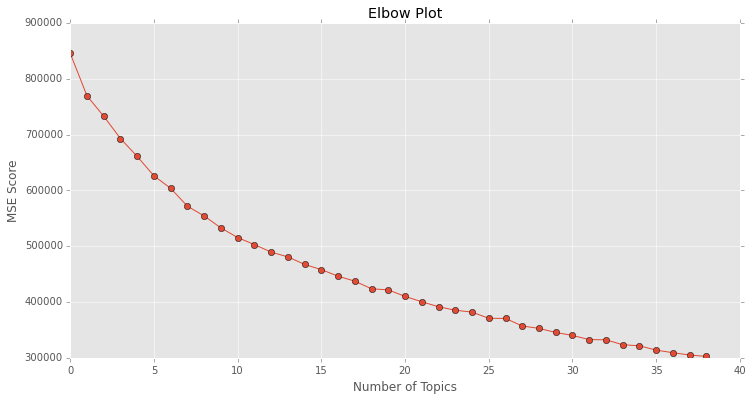

In [29]:
plt.figure(figsize=(12,6))
plt.title("Elbow Plot")
plt.xlabel("Number of Topics")
plt.ylabel("MSE Score")
errors = []
for k in range(1,40):
    nmf = NMF(n_components=k).fit(cv_X)
    W = nmf.fit_transform(cv_X);
    H = nmf.components_
    predicted = sparse.csr_matrix(W.dot(H))
    og_sparse = sparse.csr_matrix(cv_X)
    diff = numpy.absolute(og_sparse - predicted)
    errors.append(numpy.sum(numpy.square(diff.data)))
plt.plot(numpy.arange(k), errors, c='r', linestyle='-', marker= 'o');



In [30]:
nmf = NMF(n_components=35).fit(cv_X)
W = nmf.fit_transform(cv_X);
H = nmf.components_



In [31]:
# W (n_emails, n_topics)
W.shape


(6737, 35)

In [32]:
# H (n_topics, n_features)
H.shape

(35, 10000)

###Evaluating components against MetadataSubject as way to analysize accuracy

In [33]:
# emails_topic
emails_topic = pandas.DataFrame(W)
#emails_topic



In [34]:
def topic_EmailsPerMonth(topic, doc_topic, X):
    """
    Function to return count of emails with topic per year
    """
    # All emails that contain topic
    emails_with_topic = doc_topic[:,topic].nonzero()
    # 
    emails_with_topic = X[['SentFOIA','MetadataSubject']].ix[emails_with_topic]
    emails_year_topic = emails_with_topic.groupby('SentFOIA').apply(len)
    emails_year_topic.plot(kind='barh', color='green', title='Topic {:}: Emails Counts by Year'.format(topic))
    plt.ylabel('Month', rotation=0)
    print('Topic {}: {:.2%} of total emails'.format(topic, emails_year_topic.sum() / 7994.0))
    print(emails_year_topic)

Topic 5: 8.49% of total emails
SentFOIA
2009-03      4
2009-04     13
2009-05     33
2009-06     28
2009-07     24
2009-08     33
2009-09     38
2009-10     35
2009-11     36
2009-12     39
2010-01     53
2010-02     48
2010-03     28
2010-04     27
2010-05     37
2010-06     36
2010-07     17
2010-08     33
2010-09     32
2010-10     25
2010-11     20
2010-12     20
2011-04      1
2012-01      3
2012-04      1
2012-09      7
2012-10      3
2012-11      1
2012-12      3
2014-12      1
dtype: int64


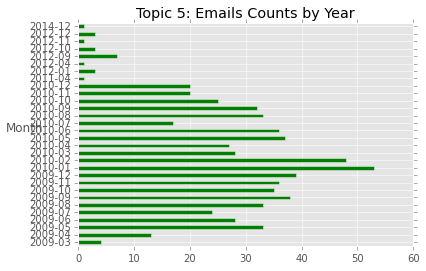

In [35]:
topic_EmailsPerMonth(5, W, df)

In [36]:
# Top Emails by Topic
def topic_topEmails(topic, n_emails, X, doc_topics):
    topN_topic_email = doc_topics[:,topic].argsort()[::-1][:n_emails]
    return X[['SentFOIA','MetadataSubject']].ix[topN_topic_email]

In [37]:
topic_topEmails(7, 10, df, W)

,SentFOIA,MetadataSubject
1712,2009-09,BRANCH SUMMARY
1301,2009-08,"DRAFT OF MONDAY, AUGUST 17TH"
6536,2012-04,LIBYA
5488,2010-08,"""MINISTER IN A SKIRT"""
1953,2009-09,HERE IS THE DRAFT AGENDA PER OUR DISCUSSION
1109,2009-07,AP/NK
2567,2009-11,#S
5168,2010-06,RAHM'S LONG GOODBYE
6615,2012-09,"RICE ON ""THIS WEEK"""
398,2009-05,


In [38]:
# Referenced NMF package doc pages for plot ideas: http://nimfa.biolab.si/nimfa.examples.documents.html
def topic_TopWords(model, feature_names, n_top_words):
    """
    Function for printing % words contained by topic, n_top_words sorted by length,
    and plots top 10 words by importance per topic
    """
    for topic_idx, topic in enumerate(model.components_):
        
        print("\n Topic {}: \n".format(topic_idx+1))
        print("Percentage of Words: {:.2%}\n".format(numpy.count_nonzero(topic) / 41961.))
        top_words = [feature_names[i] for i in topic.argsort()[::-1][:n_top_words]]
        print(' '.join(sorted(top_words,key=len,reverse=True)))
        top10_idx = topic.argsort()[::-1][:10]
        value = sorted(topic[top10_idx],reverse=False)
        
        # Horizontal Bar Plots of Top 10 weighted terms
        plt.figure(topic_idx + 1)
        plt.barh(numpy.arange(10) + .5, value, color="green", align="center")
        plt.yticks(numpy.arange(10) + .5, [feature_names[i] for i in topic.argsort()[::-1][:10]])
        plt.xlabel("Weight")
        plt.ylabel("Term")
        plt.title("Top 10 Highest Weighted Terms in Topic {}".format(topic_idx + 1))
        plt.grid(True)
        plt.show()




 Topic 1: 

Percentage of Words: 8.90%

agreement information benghazi agreement select benghazi c05739812 date united states doc c05739812 house select information date house government agreement c05739812 benghazi case doc violence people united states select house world today case date doc


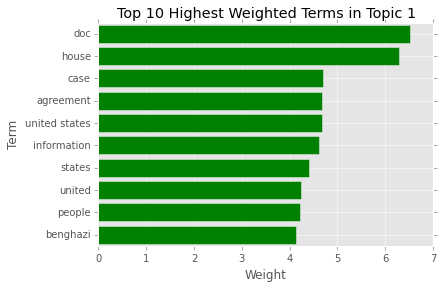


 Topic 2: 

Percentage of Words: 7.48%

administration white house wall street washington presidency president stimulus geithner politics populism security campaign strategy adviser street policy carter public obama white house times wall week year


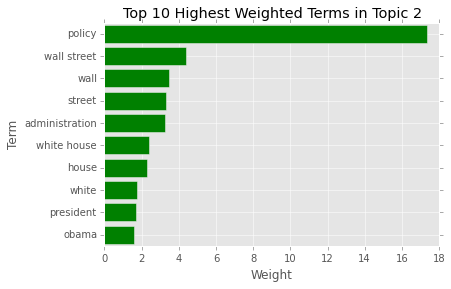


 Topic 3: 

Percentage of Words: 7.79%

republicans republican democrats alexander committee senators majority senator members chamber senate reform corker debate floor house rules party udall bill vote dodd time days year


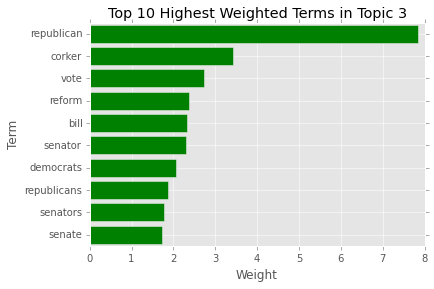


 Topic 4: 

Percentage of Words: 8.56%

americans prosperity koch industries david koch industries prosperity government americans president institute brothers movement charles company dollars million center family cancer people kochs david obama party group koch


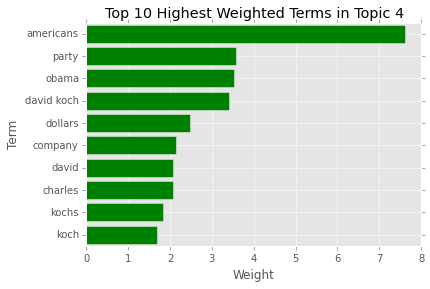


 Topic 5: 

Percentage of Words: 6.74%

secretary conference private residence meeting secretary secretary office conference room time secretary staff meeting office time conference secretary residence depart en en route meeting private airport office arrive depart route daily staff room time en


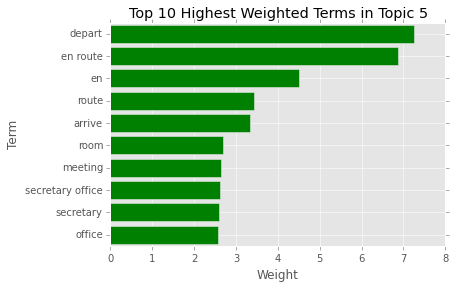


 Topic 6: 

Percentage of Words: 6.89%

american jewish human rights palestinians government netanyahu lieberman west bank american orthodox students israeli zionism america leaders percent jewish rights groups arabs human luntz jews west bank isr


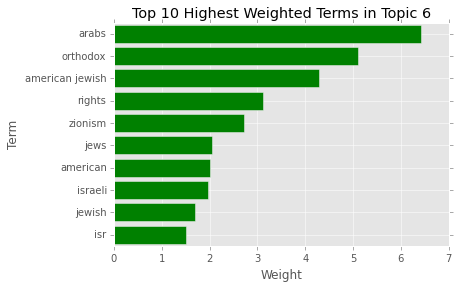


 Topic 7: 

Percentage of Words: 6.17%

counterinsurgency mcchrystal eikenberry president commander soldiers strategy official pentagon taliban command troops forces karzai afghan people obama years staff year team coin afg irq gen


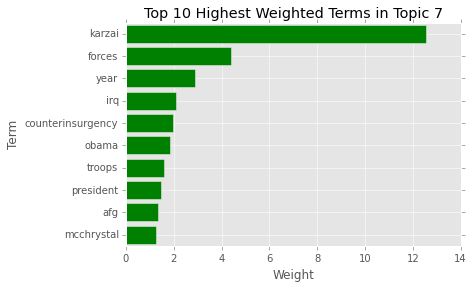


 Topic 8: 

Percentage of Words: 8.51%

white house branch wjc president lewinsky moynihan north na wjc gore clinton hillary branch carter people house north white gore book reno life time wjc hrc cvc hti na


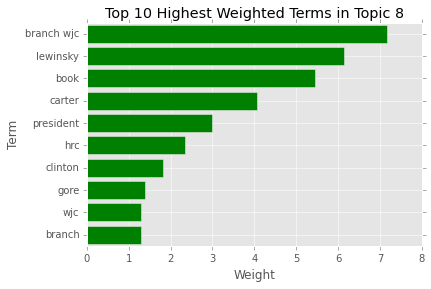


 Topic 9: 

Percentage of Words: 4.75%

favorable unfavorable unfavorable favorable president ind worn vote vol else vol wld vote percent refused rep dem dem ind opinion vol wld degree obama trend worn vote else vol rep ind dem wld


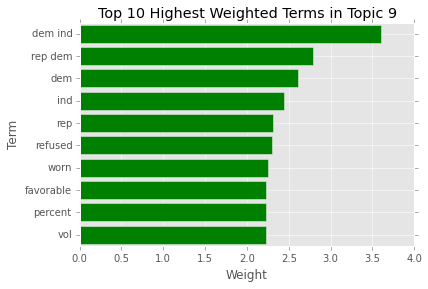


 Topic 10: 

Percentage of Words: 6.00%

health care republican healthcare government president movement abortion campaign skousen america stupak reform health people hitler obama party palin death right group house beck bill care


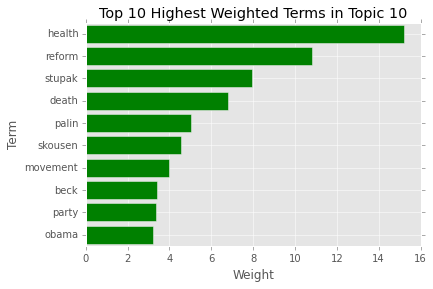


 Topic 11: 

Percentage of Words: 8.99%

birch society government republican john birch communist president american politics national skousen society buckley history federal reagan wilson party welch birch nixon right beck john year time


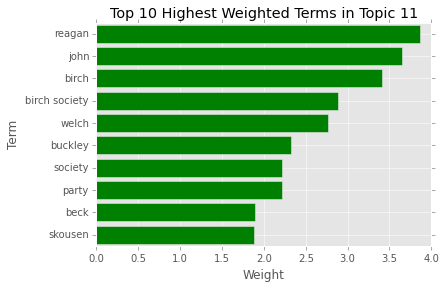


 Topic 12: 

Percentage of Words: 7.54%

presidential election preliminary analysis irn presidential chathamhouse org www chathamhouse analysis voting voting figures presidential chathamhouse election www ahmadinejad figures irn preliminary provinces election analysis province figures voters voting org uk irn org www uk


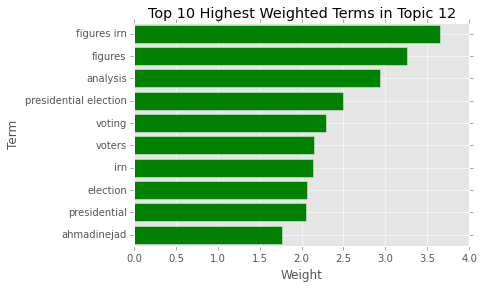


 Topic 13: 

Percentage of Words: 5.34%

gender equality afghan women development conference women afg coalition afg women security equality children afghan gender rights health karzai issues women peace girls world issue years time work afg


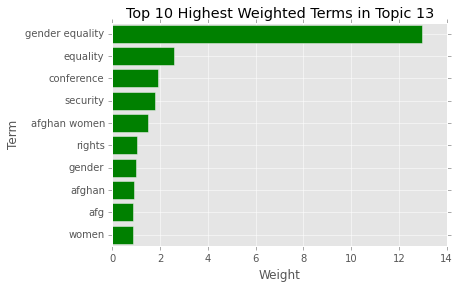


 Topic 14: 

Percentage of Words: 6.91%

prescription drug prescription white house health care care reform washington committee president industry medicare chairman campaign congress health baucus reform tauzin house white phrma care drug bill deal cost


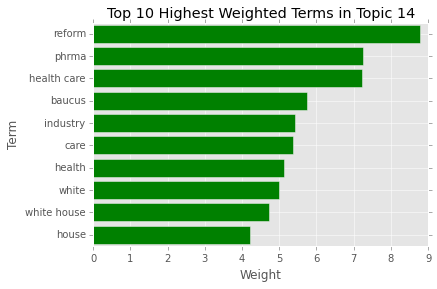


 Topic 15: 

Percentage of Words: 6.44%

agreement information benghazi agreement information state select benghazi c05739767 date c05739661 date information b5 doc c05739767 doc c05739661 house select information date house agreement c05739767 c05739661 benghazi case doc b5 case select house state case date doc b5


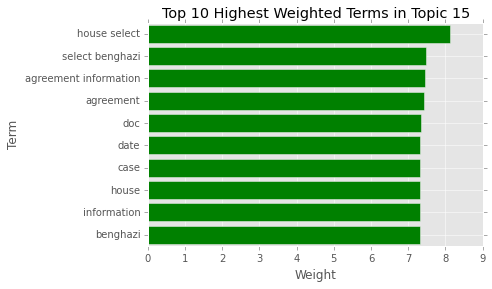


 Topic 16: 

Percentage of Words: 7.70%

northern irl devolution government mcguinness sinn fein agreement northern unionist minister politics justice cameron powers tories leader ulster party david deal fein sinn vote irl uup dup


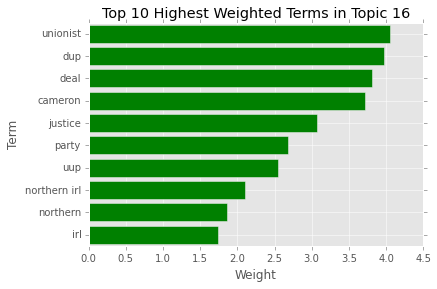


 Topic 17: 

Percentage of Words: 6.62%

united states relationship instability countries interest exchange pressure chinese towards dynasty policy states united growth demand assets world years asia rate time rest chn ind sgp


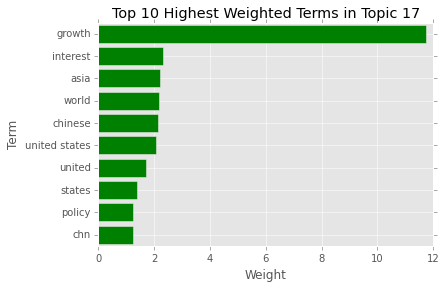


 Topic 18: 

Percentage of Words: 9.57%

hill academy georgetown ashawntea students domenici district carleto student academy schools percent school forman change police teens years youth adams staff hill kids room time city


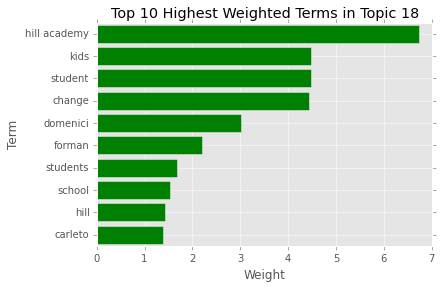


 Topic 19: 

Percentage of Words: 6.10%

john boehner republicans mr boehner washington republican nowakowski interests lobbyists business lobbyist boehner speaker voters leader attack people pelosi house staff paula chief john rove beat mr


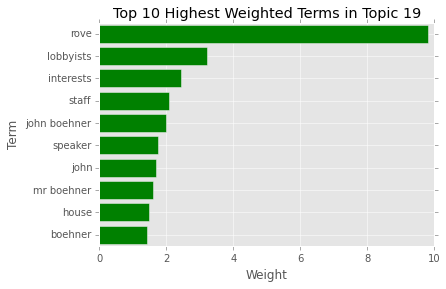


 Topic 20: 

Percentage of Words: 7.78%

united states peace process palestinians palestinian middle east holy land american security israelis tomorrow process israeli america leaders parties states united middle peace arabs arab land east holy isr


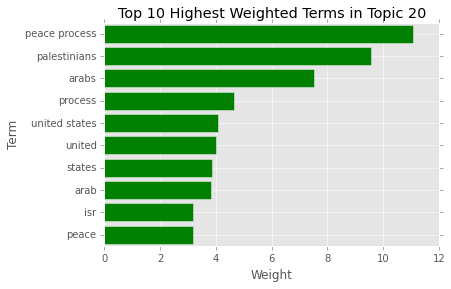


 Topic 21: 

Percentage of Words: 7.00%

american people republicans health care government democrats americans president congress american november spending populist economy country voters people health public party story right jobs bill care year


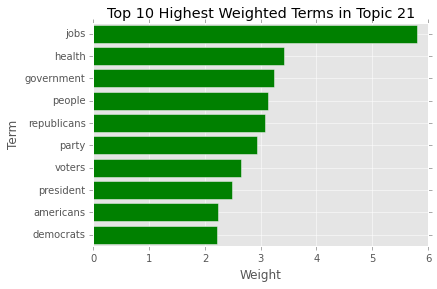


 Topic 22: 

Percentage of Words: 3.84%

percent disapproval democrats percent percent approval approval rating percent percent rating percent independents republicans disapproval health care democrats americans president secretary approval handling percent economy rating voters health obama poll care afg


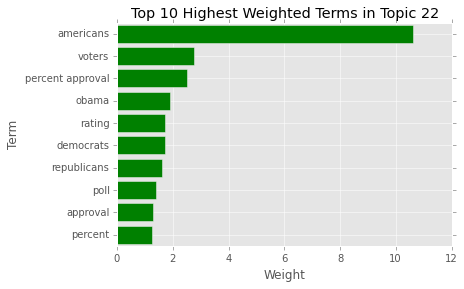


 Topic 23: 

Percentage of Words: 8.57%

administration agriculture development opportunity scientists president approach training farmers systems support people policy africa hunger health speech world prize obama women ejeta food need dr


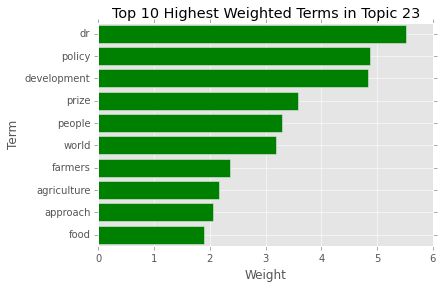


 Topic 24: 

Percentage of Words: 10.16%

maquiladoras authorities government gonzalez evidence violence murders el paso workers juarez people sharif police rascon murder policy garcia women group ponce woman city lear paso el


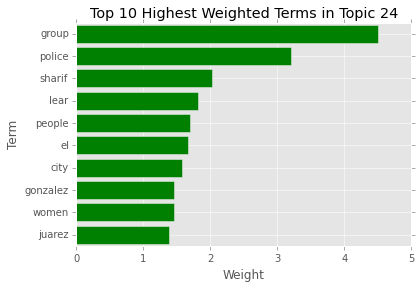


 Topic 25: 

Percentage of Words: 8.07%

washington convention convention center room washington spray bilateral bilateral room center camera seasons hotel camera spray four seasons washington convention bilateral minister seasons plenary center camera depart arrive spray hotel press room four en


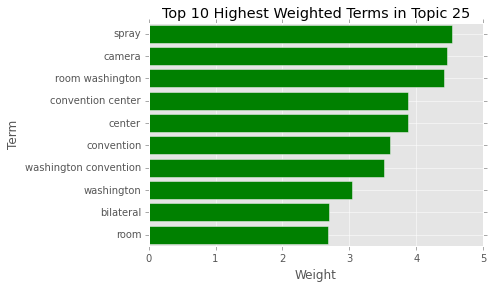


 Topic 26: 

Percentage of Words: 7.96%

united states assistance hemisphere commitment government progress nations haitian economy january efforts support people united states nation region growth health media years jobs drug work hti


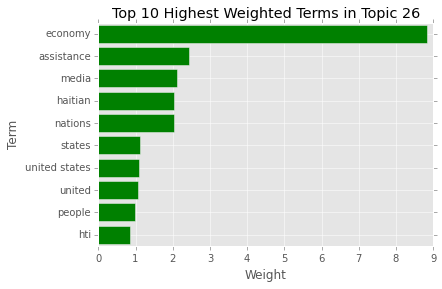


 Topic 27: 

Percentage of Words: 8.00%

revolutionary guards revolutionary intelligence government kurdistan americans american official iranian kurdish officer border hikers guards report region shourd fattal bauer iraqi taab pjak july irn irq


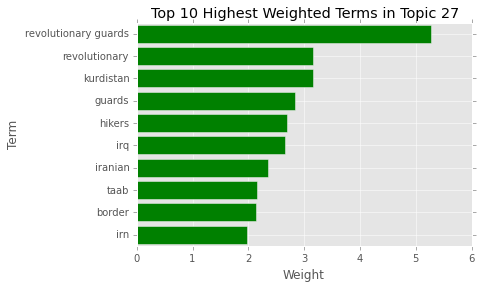


 Topic 28: 

Percentage of Words: 9.51%

united states postconflict government diplomacy diplomats secretary conflict security american dobbins efforts support united states effort forces people force smith time role irq afg fco mod


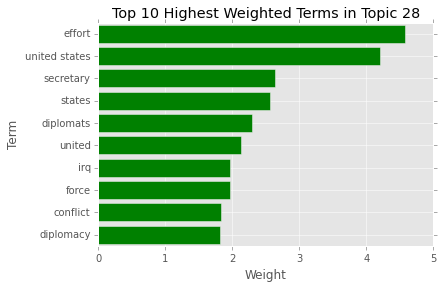


 Topic 29: 

Percentage of Words: 5.36%

ambassador eikenberry general petraeus ms gillibrand mr holbrooke mr richards ambassador gillibrand eikenberry mr boehner holbrooke bloomberg officials president richards petraeus campaign mr ford general support ford york book time mr ms


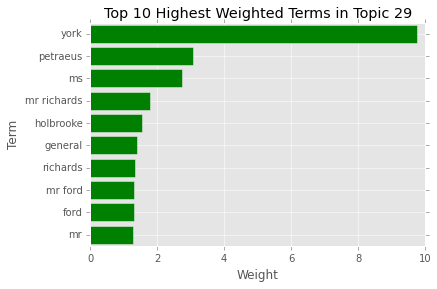


 Topic 30: 

Percentage of Words: 7.97%

hillary clinton administration white house washington president secretary diplomacy campaign security clinton hillary adviser policy issues office obama world power white trip role bush bra pak irn


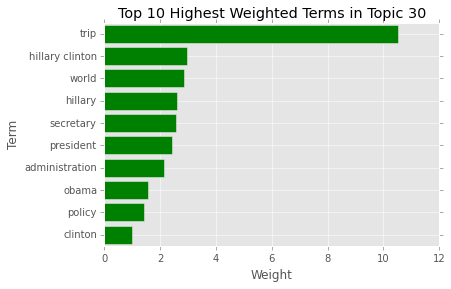


 Topic 31: 

Percentage of Words: 6.97%

afghan security afghan army government pakistani holbrooke security fighters taliban general country attacks afghan karzai forces police troops kayani nation army bill time afg pak isi ind


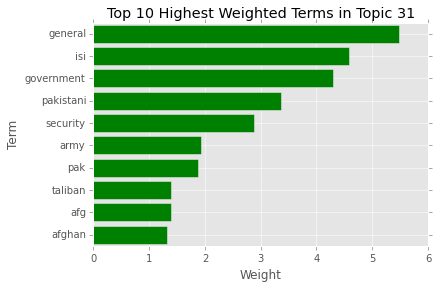


 Topic 32: 

Percentage of Words: 8.76%

intergovernmental affairs intergovernmental capacity building organizations relationships development association activities government priorities leadership officials governors countries diplomacy capacity national building meetings affairs bureaus mayors states srgia needs


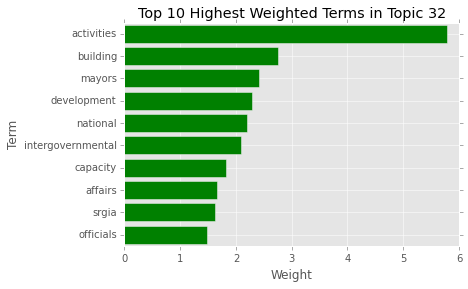


 Topic 33: 

Percentage of Words: 9.13%

community campaign american chernick israeli islamic network crusade country cordoba project center geller muslim school boston times years group party david york city time isr


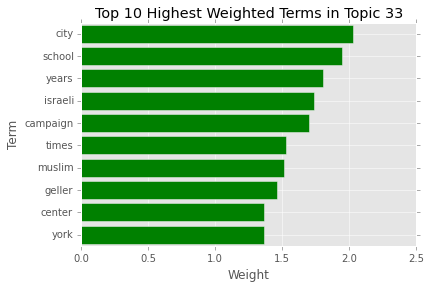


 Topic 34: 

Percentage of Words: 6.90%

administration negotiations palestinians palestinian middle east settlements government settlement jerusalem netanyahu president petraeus briefing minister israelis security israeli mullen policy hagee biden obama issue east isr


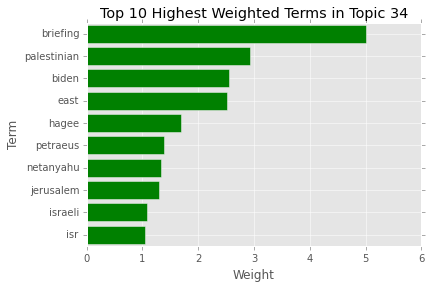


 Topic 35: 

Percentage of Words: 10.80%

vargas llosa blumenthal democracy children wilders country freedom people dobson things course europe groups vargas power group years sense child world thing llosa book life view


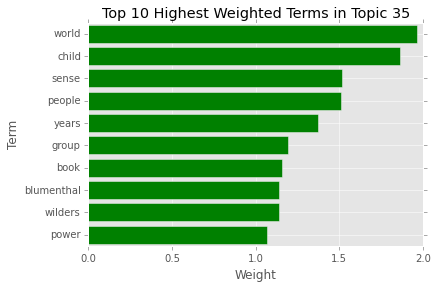

In [39]:
topic_TopWords(nmf, word_col, 25)

In [40]:
end the project here

SyntaxError: invalid syntax (<ipython-input-40-54684e8a6d94>, line 1)

##Conclusions:
* It is easy to see how the attention swifted between months to different countries according to main events that occured during the specific period. For example:
  * 2009 was Aghanistan
  * 2010 was Haiti
  * 2011-2012 was the Arab Spring and Lybia
* The focus of emails concentrated on regions in conflict of different nature. Those regions that were considered in serious conflict that involved USA received more attention. LatinAmerica was first, then regions around Aghanistan and then the region where the Arab Spring occurred.
* The messaging also involved the mentioning of countries that were considered allies to USA, with a strong focus on Israel and Oman, but also Western Europe and OTAN, as well as Pakistan, India, Japan, South Korea and Australia. In Latinamerica, Central America, Peru, Colombia and Brazil seemed to receive special mentioning.
* Comparing to the work done by G Kelly it seems that limiting the NMF to nouns only bring different kind of results. In my case, several different patterns are revealed like for example some interest by the Secretary of States about Ireland, some discussion about the Kurdish situation, interest in the situation at the Mexican border and the "maquiladoras", interest in the women and children condition in Aghanistan, African poverty, the Israeli-Palestinian conflict, and the Petraeus case. Those topics were widely part of the Obama's main political interest during the time Clinton was Secretary of the States. An interesting point apparently revealed by this technique is the apparent interest of USA for the Kurdish case even before the ISIS came to live (a deeper analysis should be carried out).
* However, this project shows several differences in results when compared to G Kelly's suggesting that in order to reveal patterns it could be necessary to carry out different levels of analyses.
* This results are just a first overview and far to be correct. The reasons of lack of veracity are not only because of the data itself but also the methodology used here. Specifically about the methodology, bear in mind that:
  * there is an unknown number of false positives as well as false negatives when approaching the search using this parsing and the modified country dataset used for the search.
  * some emails contained relevant information about countries in other forms: personalities (which could be directed related to an event in a country or region), or cities/capitals instead of countries (eg. Benghazi).

##LDA

This part of the project was not finished and left for another time.

In [ ]:
def word_clouds(model, word_list, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\n Topic {}: \n".format(topic_idx+1))
        topic_wordlist = [word_list[i] for i in model.components_[topic_idx].argsort()[::-1][:n_top_words]]
        topic_words = ' '.join(topic_wordlist)
        print(topic_words)
        #wordcloud = WordCloud(max_font_size=80,relative_scaling=.5,width=800,height=500).generate(topic_words)
        #plt.imshow(wordcloud)
        #plt.axis("off")
        #plt.show()

In [ ]:
# Source Code: https://github.com/scikit-learn/scikit-learn/tree/master/sklearn/decomposition
# Docs: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
lda_params = {'n_topics':[1,5,10,20,50]}
lda = LatentDirichletAllocation()
lda_grid = GridSearchCV(lda, lda_params)

In [ ]:
lda_grid.fit(cv_X)
lda_grid.best_estimator_

In his work, G Kelly found that the LDA converged on 5 topics after few runs, indicating that LDA is unable to disentangle by topics when several emails seem to relate to different ones. Also, G Kelly mentions that LDA does not handle short length of documents well. He suggests that an area to explore would be seeding with prior distributions of words for topics.


In [ ]:
lda_model = LatentDirichletAllocation(n_topics=5, n_jobs=-1).fit(cv_X)

In [ ]:
doctopic = lda_model.fit_transform(cv_X)

In [ ]:
def topic_EmailsPerMonth(topic, doc_topic, X):
    """
    Function to return count of emails with topic per year
    """
    # All emails that contain topic
    emails_with_topic = doc_topic[:,topic].nonzero()
    # 
    emails_with_topic = X[['SentFOIA','MetadataSubject']].ix[emails_with_topic]
    emails_year_topic = emails_with_topic.groupby('SentFOIA').apply(len)
    print(emails_year_topic)
    emails_year_topic.plot(kind='barh', color='red', title='Topic {:}: Emails Counts by Month'.format(topic))

In [ ]:
def topic_TopWords(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\n Topic {}: \n".format(topic_idx+1))
        top_words = [feature_names[i] for i in topic.argsort()[::-1][:n_top_words]]
        print(' '.join(sorted(top_words,key=len,reverse=True)))

In [ ]:
topic_TopWords(lda_model,word_col,25)

In [ ]:
lda_model.score(cv_X)

In [ ]:
word_clouds(lda_model, word_col, 50)